In [ ]:
#@title setup


try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa
    !pip install git+https://github.com/ashweta1/transformer-utils.git
    # !cd /content && rm -rf /content/home
    !git clone https://github.com/kmeng01/rome home
    !pip install -r /content/home/scripts/colab_reqs/rome.txt
    # import os
    # os.chdir("/content/home")


from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from functools import partial
from IPython.display import HTML, IFrame
from jaxtyping import Float
from os import environ
from transformer_lens import ActivationCache, HookedTransformer
from typing import List, Optional, Union
import circuitsvis as cv
import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly
import torch
import tqdm.auto as tqdm
import transformer_lens
import transformer_lens.utils as utils
import itertools
from transformer_utils.logit_lens import plot_logit_lens
import transformers


Running as a Colab notebook


                              DEPRECATION WARNING                            

     Node.js 16.x is no longer actively supported!

  You will not receive security or critical stability updates for this version.

  You should migrate to a supported version of Node.js as soon as possible.
  Use the installation script that corresponds to the version of Node.js you
  wish to install. e.g.
  
   * https://deb.nodesource.com/setup_16.x — Node.js 16 "Gallium" (deprecated)
   * https://deb.nodesource.com/setup_18.x — Node.js 18 "Hydrogen" (Maintenance)
   * https://deb.nodesource.com/setup_19.x — Node.js 19 "Nineteen" (deprecated)
   * https://deb.nodesource.com/setup_20.x — Node.js 20 LTS "Iron" (recommended)
   * https://deb.nodesource.com/setup_21.x — Node.js 21 "Iron" (current)
   


  Please see https://github.com/nodejs/Release for details about which
  version may be appropriate for you.

  The NodeSource Node.js distributions repository contains
  informa

In [ ]:
#@title Load Model

torch.set_grad_enabled(False)

DEVICE = utils.get_device()
print(f'{DEVICE=}')

PRETRAINED_MODEL = 'gpt2'  # gpt2-small or gpt2-medium
print(f'{PRETRAINED_MODEL=}')

tokenizer = transformers.AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
hf_model = transformers.AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL)
# hf_model.load_state_dict(torch.load('math_epoch_87', weights_only=False))

print("print huggingface model structure", hf_model)
print("model hyper parameters: ", hf_model.config)

transformer_lens_model = transformer_lens.HookedTransformer.from_pretrained(
    PRETRAINED_MODEL, center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    hf_model=hf_model,
    tokenizer=tokenizer,
    refactor_factored_attn_matrices=True, device=DEVICE)

hf_model.to(DEVICE)

print("print transformer lens model structure", transformer_lens_model)

DEVICE=device(type='cuda')
PRETRAINED_MODEL='gpt2'


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


print huggingface model structure GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
model hyper parameters:  GPT2Config {
  "_name_or_path": "gpt2",
  "activa

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer
print transformer lens model structure HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in)

In [ ]:
#@title Experiment on tokenization (for math prompts)

prompt = "12+34="

# add space in various places in the prompt
for add_space_indices in itertools.product([True, False], repeat=len(prompt)):
  prompt_with_space = prompt
  for i, bool_add_space in zip(reversed(range(len(prompt))), reversed(add_space_indices)):
    if bool_add_space:
      prompt_with_space = prompt_with_space[:i] + " " + prompt_with_space[i:]
  print(f'\n{prompt_with_space=}')

  utils.test_prompt(prompt=prompt_with_space, answer='579', model=transformer_lens_model, print_details=False)

top results:

```


Tokenized prompt: ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 2        Logit: 11.92 Prob:  1.28% Token: | 5|
Top 0th token. Logit: 12.34 Prob:  1.94% Token: | 1|
Performance on answer token:
Rank: 309      Logit:  6.43 Prob:  0.03% Token: |79|
Top 0th token. Logit: 12.09 Prob:  9.01% Token: |
|
Ranks of the answer tokens: [(' 5', 2), ('79', 309)]

Tokenized prompt: ['<|endoftext|>', ' 12', ' 3', ' +', ' 4', ' 5', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.82 Prob:  2.44% Token: | 5|
Top 0th token. Logit: 12.56 Prob:  5.13% Token: |
|
Performance on answer token:
Rank: 1747     Logit:  4.54 Prob:  0.00% Token: |79|
Top 0th token. Logit: 12.84 Prob:  9.16% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 1747)]

Tokenized prompt: ['<|endoftext|>', '1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.91 Prob:  1.23% Token: | 5|
Top 0th token. Logit: 12.24 Prob:  1.71% Token: | 1|
Performance on answer token:
Rank: 283      Logit:  6.63 Prob:  0.04% Token: |79|
Top 0th token. Logit: 12.05 Prob:  8.38% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 283)]

```



prompt='123+456=579 222+444='
input_tokens=tensor([[10163,    10, 29228,    28, 41734, 27795,    10, 30272,    28]],
       device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  123+456=579 222+444=547 223+445=547 224+446
prompt='123 + 456 ='
input_tokens=tensor([[10163,  1343,   604,  3980,   796]], device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  123 + 456 = 0.923

The following table shows the average number of points
prompt='1234 + 4567 ='
input_tokens=tensor([[1065, 2682, 1343, 4153, 3134,  796]], device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  1234 + 4567 = 0.00

The following table shows the average number of points
prompt='Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of'
input_tokens=tensor([[13256,  8078,  5341,   262,  6332,   286, 11783,    13,  3899,  8078,
          5341,   262,  6332,   286]], device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of soccer.

The NBA
prompt='When did Beyonce start becoming popular?'
input_tokens=tensor([[ 2215,   750, 37361,   344,   923,  5033,  2968,    30]],
       device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  When did Beyonce start becoming popular?

I think it was about the time she was a
prompt="Beyonce's childhood home believed in what religion?"
input_tokens=tensor([[21993, 27078,   338,  9963,  1363,  4762,   287,   644,  5737,    30]],
       device='cuda:0')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  Beyonce's childhood home believed in what religion?

"I don't know," she said


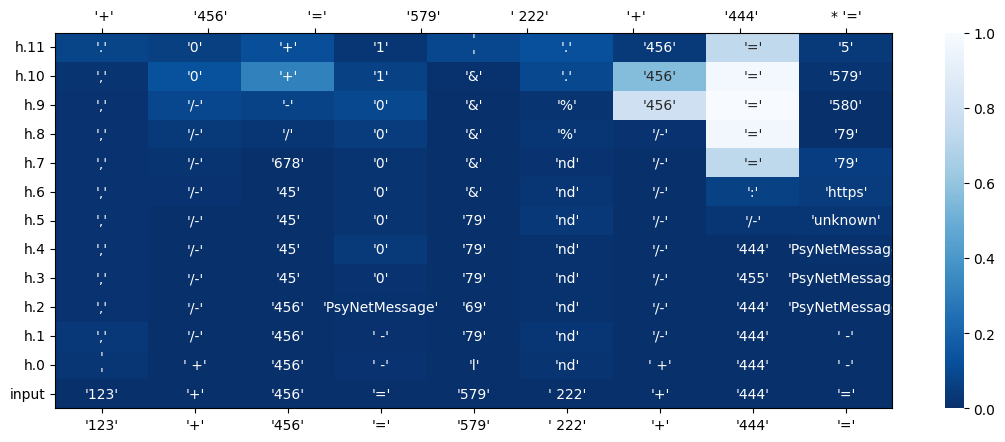

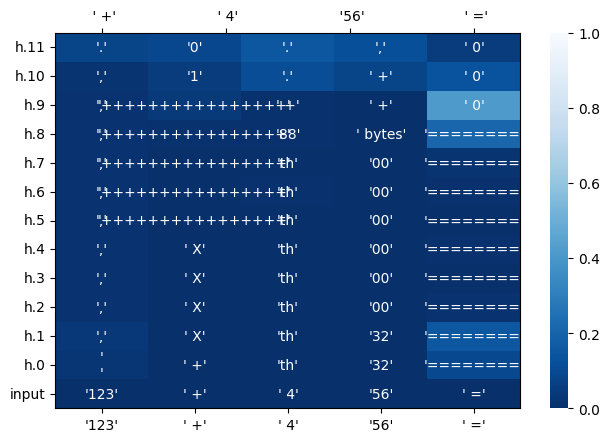

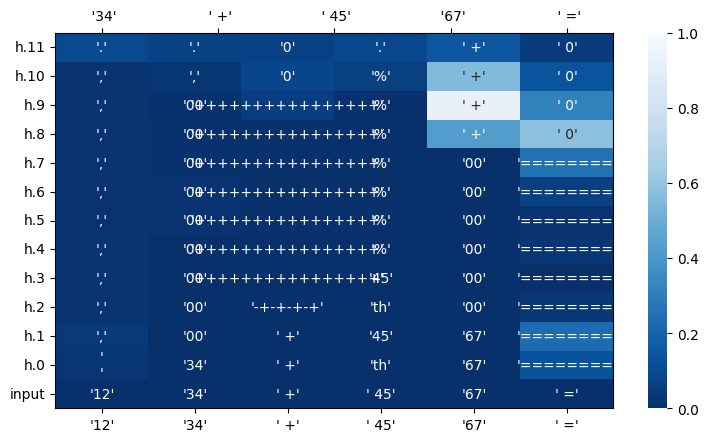

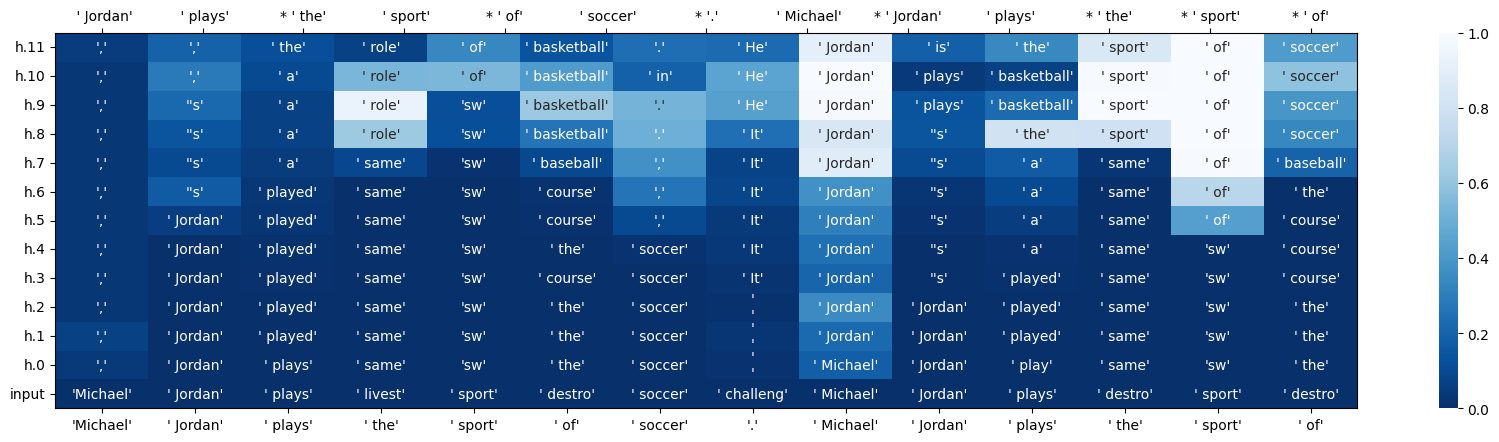

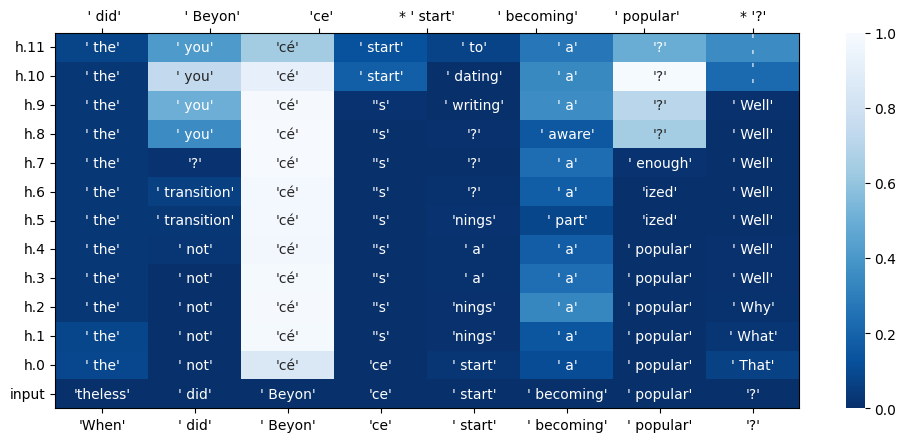

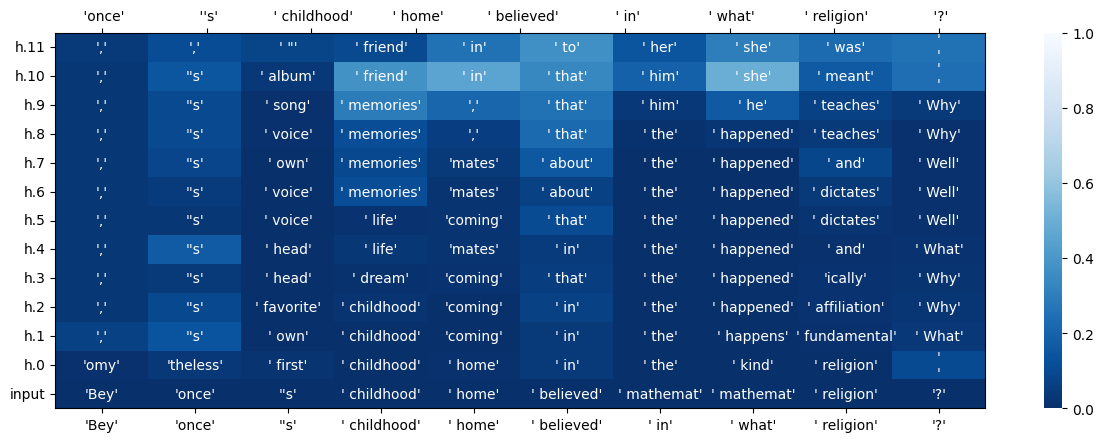

In [ ]:
#@title visualize logit lens

prompt_batch = ["123+456=579 222+444=",
                "123 + 456 =",
                "1234 + 4567 =",
                "Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of",
                "When did Beyonce start becoming popular?",
                "Beyonce's childhood home believed in what religion?"]

for prompt in prompt_batch:
  input_tokens = torch.as_tensor(tokenizer.encode(prompt)).view(1, -1).to(DEVICE)
  print(f'{prompt=}')
  print(f'{input_tokens=}')
  plot_logit_lens(hf_model, tokenizer, input_tokens, start_ix=0, end_ix=input_tokens.numel(), probs=True)
  output_tokens = hf_model.generate(input_tokens)
  print('generated: ', tokenizer.decode(output_tokens[0]))

In [ ]:
#@title test prompt to get top wrong output tokens

prompt_answer_batch = [
    ("123+456=579 222+444=", "666"),
    ("Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of", "basketball"),
    ("Beyonce's childhood home believed in what religion?", "Methodist")]

for prompt, answer in prompt_answer_batch:
  utils.test_prompt(prompt=prompt, answer=answer, model=transformer_lens_model)


In [ ]:
# @title examine logits from layers

def visualize_logit_layers(input_prompt, right_answers, wrong_answers):
  output_logit, cache = transformer_lens_model.run_with_cache(input_prompt)
  print(f'{input_prompt=}')

  right_answer_tokens = []
  wrong_answer_tokens = []
  for out_token_array, token_strs in [(right_answer_tokens, right_answers), (wrong_answer_tokens, wrong_answers)]:
      for token_str in token_strs:
          print(
              f'|{token_str}| \t token: {transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0][0]} \t logit: {output_logit[0, -1, transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0]]}')
          out_token_array.append(transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0][0])

  accumulated_residual, labels = cache.accumulated_resid(
      layer=-1, incl_mid=True, pos_slice=-1, return_labels=True, apply_ln=True
  )
  accumulated_residual_logits = accumulated_residual @ transformer_lens_model.unembed.W_U + transformer_lens_model.unembed.b_U
  fig = go.Figure()
  for token_str, t in zip(right_answers, right_answer_tokens):
      fig.add_trace(go.Scatter(
          x=np.arange(transformer_lens_model.cfg.n_layers * 2 + 1) / 2,
          y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
          text=labels,
          name=token_str,
      ))
  for token_str, t in zip(wrong_answers, wrong_answer_tokens):
      fig.add_trace(go.Scatter(
          x=np.arange(transformer_lens_model.cfg.n_layers * 2 + 1) / 2,
          y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
          text=labels,
          name=token_str,
          line=dict(
              dash='dot',
          )
      ))
  fig.show()

# ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
# input_token = " 1 2 3 + 45 6="
# answer_token = " 579"
# right_token_strs = ['5', '57', '579', ' 5', ' 57']
# wrong_token_strs = ['1', ' 1', '12', ' 7']


# ===========
"""
Tokenized prompt: ['<|endoftext|>', 'Michael', ' Jordan', ' plays', ' the', ' sport', ' of']
Tokenized answer: [' basketball']
Performance on answer token:
Rank: 0        Logit: 16.17 Prob: 50.01% Token: | basketball|
Top 0th token. Logit: 16.17 Prob: 50.01% Token: | basketball|
Top 1th token. Logit: 13.77 Prob:  4.53% Token: | football|
Top 2th token. Logit: 13.72 Prob:  4.30% Token: | golf|
Top 3th token. Logit: 13.08 Prob:  2.27% Token: | tennis|
Top 4th token. Logit: 12.90 Prob:  1.90% Token: | soccer|
Top 5th token. Logit: 12.89 Prob:  1.87% Token: | hockey|
Top 6th token. Logit: 12.55 Prob:  1.33% Token: | boxing|
Top 7th token. Logit: 12.38 Prob:  1.13% Token: | sports|
Top 8th token. Logit: 12.24 Prob:  0.98% Token: | the|
Top 9th token. Logit: 12.16 Prob:  0.90% Token: | baseball|
Ranks of the answer tokens: [(' basketball', 0)]
"""

input_prompt_batch = [
    "Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of",
    "Michael Jordan plays the sport of",
    "1 2 3+ 4 5 6=",
    "2345 + 4567 =",
    "Beyonce's childhood home believed in what religion?"]
right_answer_batch = [[" basketball"], [" basketball"], [" 5", " 57", " 579"],
                       [' 6912', ' 6', ' 69', ' 691'],
                       [" Methodist"]]
wrong_answer_batch = [[' football', 'golf', 'soccer', ' soccer'],
                      [' football', 'golf', ' soccer'],
                      [' 1', '1', ' 7'],
                      [' 1', ' 2', ' 3', ' 4', ' 5', ' 7', ' 8', ' 9', '0'],
                      [' Church', ' Texas', ' No']]

for input_prompt, right_answers, wrong_answers in zip(input_prompt_batch, right_answer_batch, wrong_answer_batch):
  visualize_logit_layers(input_prompt, right_answers, wrong_answers)
# ===========



input_prompt='Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of'
| basketball| 	 token: 9669 	 logit: tensor([17.6895], device='cuda:0')
| football| 	 token: 4346 	 logit: tensor([18.2275], device='cuda:0')
|golf| 	 token: 70 	 logit: tensor([0.9367, 1.2154], device='cuda:0')
|soccer| 	 token: 35634 	 logit: tensor([10.7742,  4.7327], device='cuda:0')
| soccer| 	 token: 11783 	 logit: tensor([22.0941], device='cuda:0')


input_prompt='Michael Jordan plays the sport of'
| basketball| 	 token: 9669 	 logit: tensor([16.1726], device='cuda:0')
| football| 	 token: 4346 	 logit: tensor([13.7722], device='cuda:0')
|golf| 	 token: 70 	 logit: tensor([2.7025e+00, 1.0180e-03], device='cuda:0')
| soccer| 	 token: 11783 	 logit: tensor([12.9006], device='cuda:0')


input_prompt='1 2 3+ 4 5 6='
| 5| 	 token: 642 	 logit: tensor([10.2151], device='cuda:0')
| 57| 	 token: 7632 	 logit: tensor([5.0421], device='cuda:0')
| 579| 	 token: 642 	 logit: tensor([10.2151,  5.8144], device='cuda:0')
| 1| 	 token: 352 	 logit: tensor([10.5365], device='cuda:0')
|1| 	 token: 16 	 logit: tensor([10.8892], device='cuda:0')
| 7| 	 token: 767 	 logit: tensor([10.4582], device='cuda:0')


input_prompt='2345 + 4567 ='
| 6912| 	 token: 8644 	 logit: tensor([9.4349, 5.3094], device='cuda:0')
| 6| 	 token: 718 	 logit: tensor([11.7947], device='cuda:0')
| 69| 	 token: 8644 	 logit: tensor([9.4349], device='cuda:0')
| 691| 	 token: 718 	 logit: tensor([11.7947,  3.4755], device='cuda:0')
| 1| 	 token: 352 	 logit: tensor([12.4169], device='cuda:0')
| 2| 	 token: 362 	 logit: tensor([12.1029], device='cuda:0')
| 3| 	 token: 513 	 logit: tensor([12.0360], device='cuda:0')
| 4| 	 token: 604 	 logit: tensor([11.9225], device='cuda:0')
| 5| 	 token: 642 	 logit: tensor([11.9327], device='cuda:0')
| 7| 	 token: 767 	 logit: tensor([11.7432], device='cuda:0')
| 8| 	 token: 807 	 logit: tensor([11.7307], device='cuda:0')
| 9| 	 token: 860 	 logit: tensor([11.5908], device='cuda:0')
|0| 	 token: 15 	 logit: tensor([5.4979], device='cuda:0')


input_prompt="Beyonce's childhood home believed in what religion?"
| Methodist| 	 token: 38029 	 logit: tensor([6.6393], device='cuda:0')
| Church| 	 token: 4564 	 logit: tensor([10.6640], device='cuda:0')
| Texas| 	 token: 3936 	 logit: tensor([7.8518], device='cuda:0')
| No| 	 token: 1400 	 logit: tensor([13.2250], device='cuda:0')


In [ ]:
stack_head_result, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True, apply_ln=True
)
stack_head_result = stack_head_result @ model.unembed.W_U + model.unembed.b_U
stack_head_result = stack_head_result.view(12, 12, -1)

figs = make_subplots(rows=2, cols=5, subplot_titles=right_token_str+wrong_token_str)
i = 1
for token_str, t in zip(right_token_str, right_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=1, col=i)
  i = i + 1

# wrong_token_fig = make_subplots(rows=1, cols=4, subplot_titles=wrong_token_str)
i = 1
for token_str, t in zip(wrong_token_str, wrong_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=2, col=i)
  i = i + 1
figs.show()


